In [523]:
import os
import datetime

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

from natsort import natsorted
from PIL import Image
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from torchinfo import summary

In [98]:
INPUT_SHAPE = 256

In [176]:
class BasicBlockDec(nn.Module):

    def __init__(self, stride=1):
        super().__init__()
        
        self.convtrans1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.convtrans2 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1)



    def forward(self, x):
        out1 = self.convtrans1(x)
        out2 = torch.relu(self.bn2(out1))
        out2 = self.convtrans2(out2)
        out2 = torch.relu(self.bn2(out2))
        final = torch.add(out1, out2)
        
        return final

In [180]:
basic = BasicBlockDec().cuda()
print(type(basic))
summary(basic, (1, 512, 8, 8), depth=6)

<class '__main__.BasicBlockDec'>


Layer (type:depth-idx)                   Output Shape              Param #
BasicBlockDec                            --                        --
├─ConvTranspose2d: 1-1                   [1, 512, 16, 16]          4,194,816
├─BatchNorm2d: 1-2                       [1, 512, 16, 16]          1,024
├─ConvTranspose2d: 1-3                   [1, 512, 16, 16]          2,359,808
├─BatchNorm2d: 1-4                       [1, 512, 16, 16]          (recursive)
Total params: 6,555,648
Trainable params: 6,555,648
Non-trainable params: 0
Total mult-adds (G): 1.68
Input size (MB): 0.13
Forward/backward pass size (MB): 3.15
Params size (MB): 26.22
Estimated Total Size (MB): 29.50

In [544]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, shape):
        super().__init__()
        if shape == 512:
            shape2 = 512
        else:
            shape2 = int(shape * 2)
        
        self.convtrans1 = nn.ConvTranspose2d(shape2, shape, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(shape)
        self.convtrans2 = nn.ConvTranspose2d(shape, shape, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(shape)
        
    def forward(self, x):
        out1 = self.convtrans1(x)
        out2 = torch.relu(self.bn1(out1))
        out2 = self.convtrans2(out2)
        out2 = torch.relu(self.bn2(out2))
        final = torch.add(out1, out2)
        
        return final

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.layer1 = BasicBlockDec(512)
        self.layer2 = BasicBlockDec(256)
        self.layer3 = BasicBlockDec(128)
        self.layer4 = BasicBlockDec(64)
        self.conv1 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

#         self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, shape):
        return 
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         x = self.linear(z)
#         x = x.view(z.size(0), 512, 1, 1)
#         x = F.interpolate(z, scale_factor=4)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
#         x = self.conv1(x)

        x = torch.sigmoid(self.conv1(x))
#         x = x.view(x.size(0), 3, INPUT_SHAPE, INPUT_SHAPE)
        return x

class AutoEncoder(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)
        self.conv1 = nn.Conv2d(512, 512, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=1, stride=1)

    def forward(self, x):
#         mean, logvar = self.encoder(x)
        x = self.encoder(x)
        x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(x)
        return x
    


In [545]:
ae = AutoEncoder(z_dim=10).cuda()
summary(ae, (1, 3, INPUT_SHAPE, INPUT_SHAPE), depth=6)

Layer (type:depth-idx)                        Output Shape              Param #
AutoEncoder                                   --                        --
├─ResNet18Enc: 1-1                            [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         1,728
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─MaxPool2d: 2-3                         [1, 64, 64, 64]           --
│    └─Sequential: 2-4                        [1, 64, 64, 64]           --
│    │    └─BasicBlockEnc: 3-1                [1, 64, 64, 64]           --
│    │    │    └─Conv2d: 4-1                  [1, 64, 64, 64]           36,864
│    │    │    └─BatchNorm2d: 4-2             [1, 64, 64, 64]           128
│    │    │    └─Conv2d: 4-3                  [1, 64, 64, 64]           36,864
│    │    │    └─BatchNorm2d: 4-4             [1, 64, 64, 64]           128
│    │    │    └─Sequential: 4-5              [1, 64, 64, 64]           --
│    │

In [557]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 75
LR = 0.0004

In [558]:
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [559]:

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
}

In [560]:
train_root = './cap_dataset/white_omote_crop/train/good/'  # train dataの保存してあるディレクトリ


In [561]:
train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [569]:
model = AutoEncoder(z_dim=10).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,
                             weight_decay=1e-5)

In [564]:
for epoch in range(EPOCHS):
    total_loss = 0
    
    for img in train_loader:
        img = Variable(img).cuda()
        
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, total_loss))
        


KeyboardInterrupt: 

In [566]:
def train(model,dataloader,otpimizer,criterion,num_epochs):

    for epoch in range(1,num_epochs+1):
        
#         model.train()
        
        total_loss = 0
        corrects = 0
        total = 0

        with tqdm(total=len(dataloader),unit="batch") as pbar:
            pbar.set_description(f"Epoch[{epoch}/{num_epochs}]")
            for imgs in dataloader: 
#                 imgs,labels=imgs.to(device),labels.to(device)
                imgs = Variable(img).cuda()
                output = model(imgs)
                loss = criterion(output, imgs)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

#                 predicted=torch.argmax(output,dim=1) ## dimあってる？
#                 corrects+=(predicted==labels).sum()
                total += imgs.size(0)

                #loss関数で通してでてきたlossはCrossEntropyLossのreduction="mean"なので平均
                #batch sizeをかけることで、batch全体での合計を今までのloss_sumに足し合わせる
#                 loss_sum += loss * imgs.size(0) 

#                 accuracy=corrects.item()/total
#                 running_loss = loss_sum / total
                total_loss += loss.data / total
                pbar.set_postfix({"loss":total_loss.item()})
                pbar.update(1)

In [570]:
EPOCHS = 48
train(model, train_loader, optimizer, criterion, EPOCHS)

Epoch[48/48]: 100%|██████████| 5/5 [00:08<00:00,  1.61s/batch, loss=9.37e-6]


In [571]:
today = datetime.datetime.today()
today = today.strftime('%m%d%H%M')
pkl_path = "resnetAE_{}_{}epoch.pkl".format(today, EPOCHS)

In [572]:
torch.save(model.state_dict(), pkl_path)

In [573]:
# pkl_path = "resnetAE_04060554.pkl"
model = AutoEncoder(z_dim=10).cuda()
model.load_state_dict(torch.load(pkl_path))
model.eval()

AutoEncoder(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [574]:
test_root = './cap_dataset/white_omote_crop/test'

In [575]:
test_dataset = LoadFromFolder(test_root, transform=transform_dict["test"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [576]:
for img in test_loader:
    img = Variable(img).cuda()
    save_image_size_for_z = 4
    save_images = model(img)
    save_image(save_images[:save_image_size_for_z], "result.png", nrow=4)

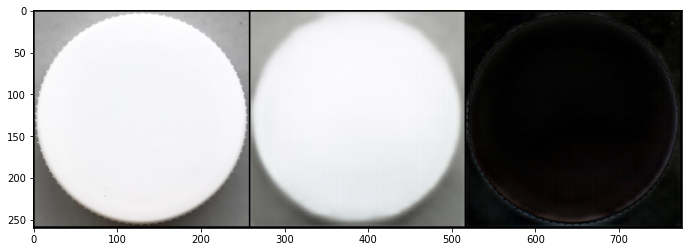

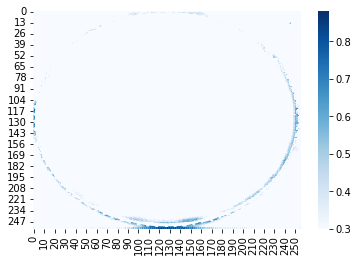

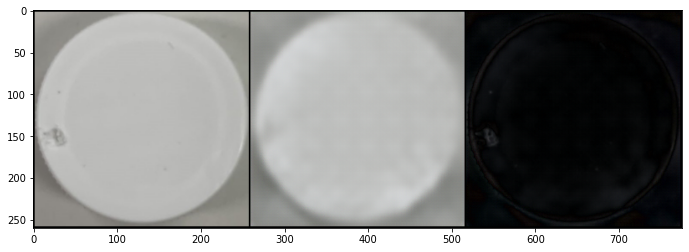

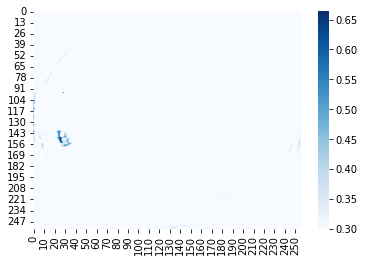

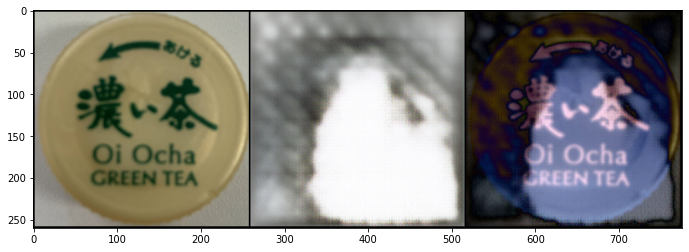

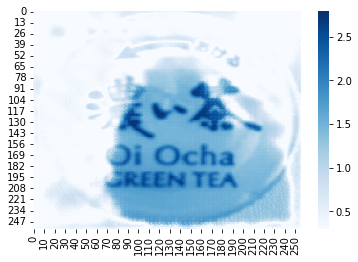

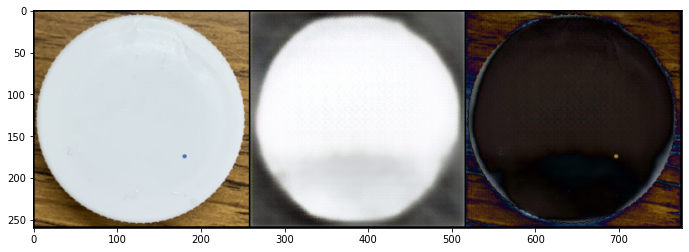

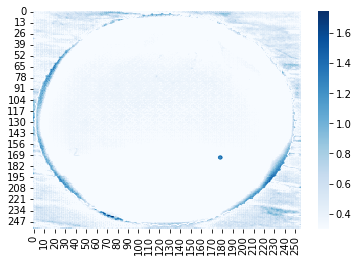

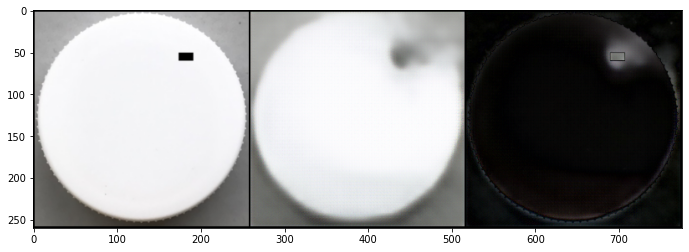

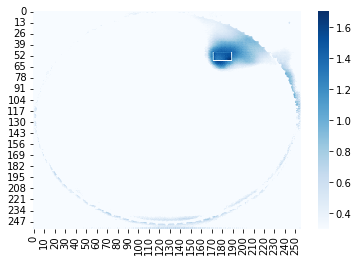

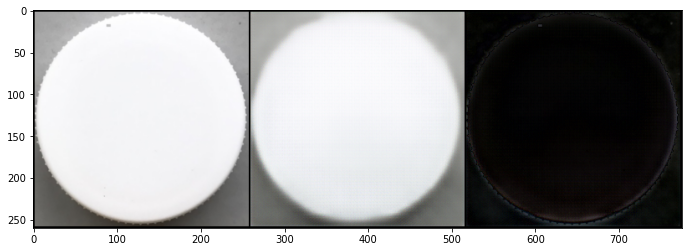

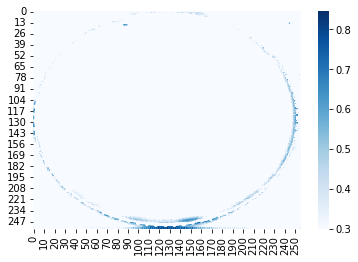

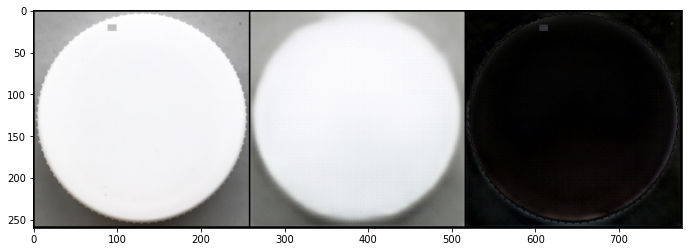

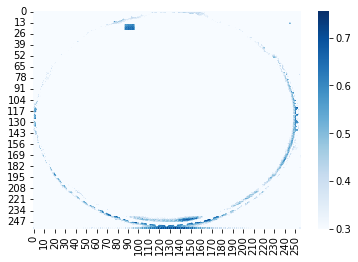

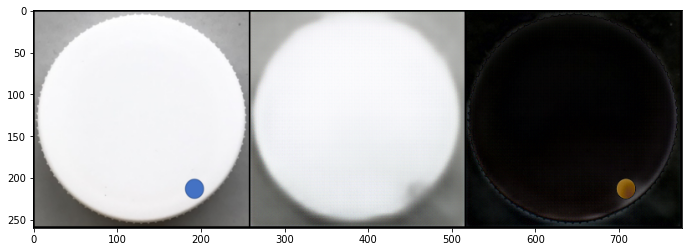

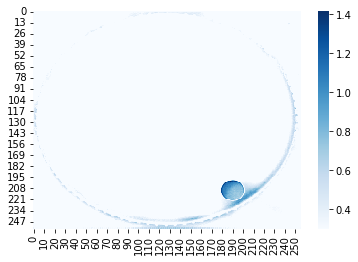

In [580]:
for idx in range(len(test_dataset)):

    x = test_dataset[idx].view(1, 3, 256, 256).cuda()
#     x = Variable(test_dataset[idx]).cuda()
    constructed = model(x)
    
#     loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - constructed)
#     print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), constructed.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()
    
    diff_rgb = diff_img.squeeze()
    diff_rgb = diff_rgb[0, :, :] + diff_rgb[1, :, :] + diff_rgb[2, :, :]
    H = signal.convolve2d(diff_rgb.cpu().detach().numpy(), np.ones((4,4)), mode='same')
    sns.heatmap(diff_rgb.cpu().detach().numpy(), cmap='Blues', vmin=0.3)

In [510]:
diff_rgb = diff_img.squeeze()

In [511]:
from scipy import signal
import seaborn as sns


In [512]:
diff_rgb.shape

torch.Size([3, 256, 256])

In [513]:
diff_rgb = diff_rgb[0, :, :] + diff_rgb[1, :, :] + diff_rgb[2, :, :]

In [514]:
H = signal.convolve2d(diff_rgb.cpu().detach().numpy(), np.ones((4,4)), mode='same')

In [515]:
diff_img.cpu().detach().numpy().shape

(1, 3, 256, 256)

<AxesSubplot:>

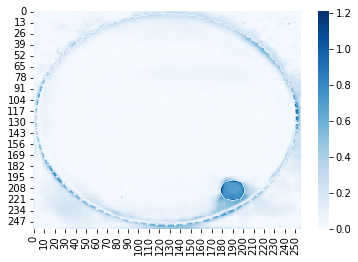

In [516]:
sns.heatmap(diff_rgb.cpu().detach().numpy(), cmap='Blues', vmin=0)

In [416]:
diff_img

tensor([[[[0.1251, 0.1781, 0.1103,  ..., 0.2197, 0.1661, 0.1301],
          [0.0809, 0.0554, 0.1316,  ..., 0.1716, 0.2520, 0.1953],
          [0.0530, 0.1134, 0.0211,  ..., 0.2340, 0.0768, 0.1414],
          ...,
          [0.0590, 0.0330, 0.1223,  ..., 0.2202, 0.2947, 0.2363],
          [0.0645, 0.0617, 0.1238,  ..., 0.2907, 0.1651, 0.2410],
          [0.0631, 0.0696, 0.0317,  ..., 0.2522, 0.2644, 0.2170]],

         [[0.0743, 0.0101, 0.0075,  ..., 0.0483, 0.0559, 0.0741],
          [0.0821, 0.0269, 0.0585,  ..., 0.0947, 0.0458, 0.0413],
          [0.0647, 0.0403, 0.0177,  ..., 0.0795, 0.0547, 0.0641],
          ...,
          [0.1166, 0.0316, 0.0920,  ..., 0.1095, 0.0761, 0.0810],
          [0.1859, 0.1844, 0.1789,  ..., 0.1315, 0.0840, 0.1268],
          [0.2622, 0.1736, 0.2457,  ..., 0.0736, 0.0291, 0.0096]],

         [[0.1693, 0.1432, 0.1804,  ..., 0.0343, 0.0824, 0.0320],
          [0.1159, 0.1575, 0.0856,  ..., 0.0147, 0.0155, 0.0080],
          [0.2191, 0.1642, 0.2021,  ..., 0